In [1]:
%load_ext cudf.pandas
%load_ext cuml.accel
!pip install --upgrade -qq shap

[2025-09-28 11:20:41.607] [CUML] [info] cuML: Installed accelerator for sklearn.


2025-09-28 11:20:58.034157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759058458.398668      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759058458.493963      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2025-09-28 11:21:23.581] [CUML] [info] cuML: Installed accelerator for umap.
[2025-09-28 11:21:23.689] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-09-28 11:21:23.689] [CUML] [info] cuML: Successfully initialized accelerator.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.4 MB/s eta 0:00:00


In [2]:
##### IMPORT LIBRARIES #####
import torch
import sys
import os
import gc

import joblib
import pickle

## -- DATA MANIPUALATION --
import numpy as np
import pandas as pd
import random

## -- VISUALISATION --
import shap
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image

## -- FUNCTIONAL TOOLS --
from time import time
from google.colab import files
from tqdm.notebook import tqdm
from itertools import combinations

# ## SCIKIT-LEARN
import sklearn
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector as SFS1
from mlxtend.feature_selection import SequentialFeatureSelector as SFS2

# -- GBDTs --
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cgb
    # import optuna
except:
    %pip install -qq -U catboost # optuna
    import catboost as cgb
    # import optuna

import warnings

In [3]:
np.__version__, pd.__version__, sns.__version__, sklearn.__version__

('1.26.4', '2.2.3', '0.12.2', '1.2.2')

In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")

## -- Set Global Seed --
SEED = 42
def set_global_seed(seed = SEED):
    """Sets the global random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)

set_global_seed()

## -- Set Device-Agnostic code --
USE_cud = "cuda" if torch.cuda.is_available() else "cpu"
USE_gpu = "gpu" if torch.cuda.is_available() else "cpu"
USE_GPU = "GPU" if torch.cuda.is_available() else "CPU"

COLOR = '\033[33m'
RESET = '\033[0m'

In [5]:
### Load Data ###
PATH       = "/kaggle/input/playground-series-s5e9/"
train      = pd.read_csv(PATH +"train.csv", index_col='id') #.drop('id', axis=1)
test       = pd.read_csv(PATH +"test.csv", index_col='id') #.drop('id', axis=1)

orig       = pd.read_csv("/kaggle/input/bpm-prediction-challenge/Train.csv")
orig['id'] = np.arange(len(orig))
orig       = orig.set_index('id')

submit     = pd.read_csv(PATH+"sample_submission.csv")

TARGET     = "BeatsPerMinute"
FEATURES   = test.columns.tolist()

In [6]:
# ### Load Data ###
# train      = pd.read_csv("train.csv", index_col='id') #.drop('id', axis=1)
# test       = pd.read_csv("test.csv", index_col='id') #.drop('id', axis=1)

# orig       = pd.read_csv("orig.csv")
# orig['id'] = np.arange(len(orig))
# orig       = orig.set_index('id')

# submit     = pd.read_csv("sample_submission.csv")

# TARGET     = "BeatsPerMinute"
# FEATURES   = test.columns.tolist()

In [7]:
train.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
RhythmScore,524164.0,0.632843,0.156899,0.076900,0.515850,0.634686,0.739179,0.975000
AudioLoudness,524164.0,-8.379014,4.616221,-27.509725,-11.551933,-8.252499,-4.912298,-1.357000
VocalContent,524164.0,0.074443,0.049939,0.023500,0.023500,0.066425,0.107343,0.256401
AcousticQuality,524164.0,0.262913,0.223120,0.000005,0.069413,0.242502,0.396957,0.995000
InstrumentalScore,524164.0,0.117690,0.131845,0.000001,0.000001,0.074247,0.204065,0.869258
LivePerformanceLikelihood,524164.0,0.178398,0.118186,0.024300,0.077637,0.166327,0.268946,0.599924
MoodScore,524164.0,0.555843,0.225480,0.025600,0.403921,0.564817,0.716633,0.978000
TrackDurationMs,524164.0,241903.692949,59326.601501,63973.000000,207099.876625,243684.058150,281851.658500,464723.228100
Energy,524164.0,0.500923,0.289952,0.000067,0.254933,0.511800,0.746000,1.000000
BeatsPerMinute,524164.0,119.034899,26.468077,46.718000,101.070410,118.747660,136.686590,206.037000


In [9]:
test.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
count,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000
mean,0.632591,-8.377495,0.074475,0.262903,0.117407,0.178317,0.555861,241753.736419,0.500545
std,0.157229,4.622288,0.050024,0.222899,0.131628,0.118165,0.226218,59103.896616,0.290550
min,0.140859,-27.442731,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067
25%,0.514918,-11.550095,0.023500,0.069448,0.000001,0.077821,0.403788,207518.151300,0.253817
50%,0.634556,-8.253186,0.066432,0.242412,0.073968,0.165956,0.566015,243584.585400,0.511867
75%,0.739179,-4.903740,0.107302,0.396870,0.202977,0.268133,0.716694,281737.445300,0.746133
max,0.975000,-1.357000,0.258857,0.995000,0.680914,0.599544,0.978000,449288.808400,0.999867


In [10]:
orig.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000
mean,0.597370,-8.441599,0.083957,0.280623,0.136972,0.193121,0.523717,241743.824913,0.500550,118.968750
std,0.176921,4.727868,0.058226,0.238181,0.158300,0.135068,0.241670,67216.815488,0.288769,26.566071
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,0.474349,-11.659427,0.023500,0.061750,0.000001,0.075404,0.351998,196588.623600,0.250600,100.888445
50%,0.600233,-8.236074,0.072629,0.252848,0.082805,0.180057,0.525871,241235.859000,0.500800,118.733631
75%,0.720912,-4.829767,0.122715,0.441652,0.236554,0.287646,0.699439,286987.805700,0.750600,136.728906
max,0.975000,-1.357000,0.346387,0.995000,0.890385,0.803157,0.978000,519650.691100,1.000000,206.037000


In [11]:
# Check if column names are the same regardless of order
are_same_set = set(train[FEATURES]) == set(test[FEATURES])
print(f"Are column names the same regardless of order (train vs test)? {are_same_set}")

# Check if column names are the same and in the same order
are_same_exact = train[FEATURES].equals(test[FEATURES])
print(f"Are column names exactly the same and in the same order (train vs test)? {are_same_exact}")

Are column names the same regardless of order (train vs test)? True
Are column names exactly the same and in the same order (train vs test)? False


In [12]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
Train,322528,310411,229305,270478,218979,279591,306504,377442,11606
Original,14354,13311,10892,11833,9435,12283,13689,14567,14633
Test,116151,110402,84370,97364,79221,101149,109993,133624,10465


### FEATURE ENGINEERING

In [13]:
## -- CREATE FEATURES -- ##
def create_features(train, test):
    # train = train.copy()
    # test  = test.copy()
    ## -- Feature 1: Use original as features
    ORIG_FEATURES = []
    
    print(f"Merging {len(FEATURES)} features... ", end="")
    for c in FEATURES:
        tmp = orig.groupby(c)[TARGET].mean()
        n = f"orig_{c}"
        print(f"{n}, ",end="")
        tmp.name = n
        train = train.merge(tmp, on=c, how='left')
        test = test.merge(tmp, on=c, how='left')
        
        ORIG_FEATURES.append(n)

    print()

    ## -- Feature 3: Quartile and Decile features
    QT = 4
    DE = 10
    BINS = []

    print(f"Creating {QT} & {DE} bins:")
    for i, col in enumerate(FEATURES, 1):
        print(f"Feat_{i}.. ", end="")

        # Calculate quantiles based on the training set
        QT_TRAIN = pd.qcut(train[col], q=QT, labels=False, duplicates='drop')
        DE_TRAIN = pd.qcut(train[col], q=DE, labels=False, duplicates='drop')

        QUAD = f"qt_{col.lower()}"
        DECI  = f"de_{col.lower()}"
        # Add binned features to train
        train[QUAD] = QT_TRAIN
        train[DECI] = DE_TRAIN

        # Use the training quantiles to bin the test set
        QT_BINS = train[col].quantile(np.linspace(0, 1, QT+1))
        DE_BINS = train[col].quantile(np.linspace(0, 1, DE+1))

        EXTRA = dict(labels=False, include_lowest=True, duplicates='drop')

        test[QUAD] = pd.cut(test[col], bins=QT_BINS, **EXTRA)
        test[DECI] = pd.cut(test[col], bins=DE_BINS, **EXTRA)

        # Handle cases where pd.cut returns NaN
        test[QUAD] = test[QUAD].fillna(-1)
        test[DECI] = test[DECI].fillna(-1)

        # # Convert to category
        # train[QUAD] = train[QUAD].astype("category")
        # train[DECI] = train[DECI].astype("category")

        # test[QUAD] = test[QUAD].astype("category")
        # test[DECI] = test[DECI].astype("category")

        BINS.append(QUAD)
        BINS.append(DECI)

    ## -- Feature 5: Pairwise combinations --
    TE = []
    for n in [2]:
        for cols in tqdm(list(combinations(FEATURES, n)), desc="Creating combinations"):
            name = '-'.join(sorted(cols))

            # Create combos by concatenating string representations
            train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

            # if n == 3: # --> Create 3-combo
            #     train[name] += '_' + train[cols[2]].astype(str)
            #     test[name] += '_' + test[cols[2]].astype(str)

            # Fit the category encoder ONLY on the training data
            train[name] = train[name].astype('category')
            cat = train[name].cat
            # Apply consistent encoding across datasets
            train[name] = train[name].cat.codes
            # Use the fitted category to transform the test set
            test[name] = pd.Categorical(test[name], categories=cat.categories).codes

            TE.append(name)

    ##### ====================================================================== #####
    #####  ORIGINAL FEATURES OPERATIONS
    ##### ====================================================================== #####
    orig_BINS = []

    print(f"Creating {QT} & {DE} bins - ORIGNAL:")
    for i, col in enumerate(ORIG_FEATURES, 1):
        print(f"Feat_{i}.. ", end="")

        # Calculate quantiles based on the training set
        QT_TRAIN = pd.qcut(train[col], q=QT, labels=False, duplicates='drop')
        DE_TRAIN = pd.qcut(train[col], q=DE, labels=False, duplicates='drop')

        QUAD = f"qt_{col.lower()}"
        DECI  = f"de_{col.lower()}"
        # Add binned features to train
        train[QUAD] = QT_TRAIN
        train[DECI] = DE_TRAIN

        # Use the training quantiles to bin the test set
        QT_BINS = train[col].quantile(np.linspace(0, 1, QT+1))
        DE_BINS = train[col].quantile(np.linspace(0, 1, DE+1))

        EXTRA = dict(labels=False, include_lowest=True, duplicates='drop')

        test[QUAD] = pd.cut(test[col], bins=QT_BINS, **EXTRA)
        test[DECI] = pd.cut(test[col], bins=DE_BINS, **EXTRA)

        # Handle cases where pd.cut returns NaN
        test[QUAD] = test[QUAD].fillna(-1)
        test[DECI] = test[DECI].fillna(-1)
        
        # # Convert to category
        # train[QUAD] = train[QUAD].astype("category")
        # train[DECI] = train[DECI].astype("category")

        # test[QUAD] = test[QUAD].astype("category")
        # test[DECI] = test[DECI].astype("category")

        orig_BINS.append(QUAD)
        orig_BINS.append(DECI)

    # Feature 5: Pairwise combinations
    orig_TE = []
    for n in [2]:
        for cols in tqdm(list(combinations(ORIG_FEATURES, n)), desc="Creating combinations"):
            name = '-'.join(sorted(cols))

            # Create combos by concatenating string representations
            train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

            # if n == 3: # --> Create 3-combo
            #     train[name] += '_' + train[cols[2]].astype(str)
            #     test[name] += '_' + test[cols[2]].astype(str)

            # Fit the category encoder ONLY on the training data
            train[name] = train[name].astype('category')
            cat = train[name].cat
            # Apply consistent encoding across datasets
            train[name] = train[name].cat.codes
            # Use the fitted category to transform the test and original sets
            test[name] = pd.Categorical(test[name], categories=cat.categories).codes

            orig_TE.append(name)

    print("Feature Engineering Complete!!!")
    print(f"-> Binned features   : {len(BINS+orig_BINS)}")
    print(f"-> Combinations (TE) : {len(TE+orig_TE)}")
    print(f"---> TOTAL FEATURES  : {len(test.columns)}")

    return train, test, TE, orig_TE, BINS, orig_BINS

In [14]:
train, test, TE, orig_TE, BINS, orig_BINS = create_features(train, test)

Merging 9 features... orig_RhythmScore, orig_AudioLoudness, orig_VocalContent, orig_AcousticQuality, orig_InstrumentalScore, orig_LivePerformanceLikelihood, orig_MoodScore, orig_TrackDurationMs, orig_Energy, 
Creating 4 & 10 bins:
Feat_1.. Feat_2.. Feat_3.. Feat_4.. Feat_5.. Feat_6.. Feat_7.. Feat_8.. Feat_9.. 

Creating combinations:   0%|          | 0/36 [00:00<?, ?it/s]

Creating 4 & 10 bins - ORIGNAL:
Feat_1.. Feat_2.. Feat_3.. Feat_4.. Feat_5.. Feat_6.. Feat_7.. Feat_8.. Feat_9.. 

Creating combinations:   0%|          | 0/36 [00:00<?, ?it/s]

Feature Engineering Complete!!!
-> Binned features   : 36
-> Combinations (TE) : 72
---> TOTAL FEATURES  : 126


In [15]:
display(train.head())
display(train.info())
train.shape, test.shape

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute,orig_RhythmScore,orig_AudioLoudness,orig_VocalContent,orig_AcousticQuality,orig_InstrumentalScore,orig_LivePerformanceLikelihood,orig_MoodScore,orig_TrackDurationMs,orig_Energy,qt_rhythmscore,de_rhythmscore,qt_audioloudness,de_audioloudness,qt_vocalcontent,de_vocalcontent,qt_acousticquality,de_acousticquality,qt_instrumentalscore,de_instrumentalscore,qt_liveperformancelikelihood,de_liveperformancelikelihood,qt_moodscore,de_moodscore,qt_trackdurationms,de_trackdurationms,qt_energy,de_energy,AudioLoudness-RhythmScore,RhythmScore-VocalContent,AcousticQuality-RhythmScore,InstrumentalScore-RhythmScore,LivePerformanceLikelihood-RhythmScore,MoodScore-RhythmScore,RhythmScore-TrackDurationMs,Energy-RhythmScore,AudioLoudness-VocalContent,AcousticQuality-AudioLoudness,AudioLoudness-InstrumentalScore,AudioLoudness-LivePerformanceLikelihood,AudioLoudness-MoodScore,AudioLoudness-TrackDurationMs,AudioLoudness-Energy,AcousticQuality-VocalContent,InstrumentalScore-VocalContent,LivePerformanceLikelihood-VocalContent,MoodScore-VocalContent,TrackDurationMs-VocalContent,Energy-VocalContent,AcousticQuality-InstrumentalScore,AcousticQuality-LivePerformanceLikelihood,AcousticQuality-MoodScore,AcousticQuality-TrackDurationMs,AcousticQuality-Energy,InstrumentalScore-LivePerformanceLikelihood,InstrumentalScore-MoodScore,InstrumentalScore-TrackDurationMs,Energy-InstrumentalScore,LivePerformanceLikelihood-MoodScore,LivePerformanceLikelihood-TrackDurationMs,Energy-LivePerformanceLikelihood,MoodScore-TrackDurationMs,Energy-MoodScore,Energy-TrackDurationMs,qt_orig_rhythmscore,de_orig_rhythmscore,qt_orig_audioloudness,de_orig_audioloudness,qt_orig_vocalcontent,de_orig_vocalcontent,qt_orig_acousticquality,de_orig_acousticquality,qt_orig_instrumentalscore,de_orig_instrumentalscore,qt_orig_liveperformancelikelihood,de_orig_liveperformancelikelihood,qt_orig_moodscore,de_orig_moodscore,qt_orig_trackdurationms,de_orig_trackdurationms,qt_orig_energy,de_orig_energy,orig_AudioLoudness-orig_RhythmScore,orig_RhythmScore-orig_VocalContent,orig_AcousticQuality-orig_RhythmScore,orig_InstrumentalScore-orig_RhythmScore,orig_LivePerformanceLikelihood-orig_RhythmScore,orig_MoodScore-orig_RhythmScore,orig_RhythmScore-orig_TrackDurationMs,orig_Energy-orig_RhythmScore,orig_AudioLoudness-orig_VocalContent,orig_AcousticQuality-orig_AudioLoudness,orig_AudioLoudness-orig_InstrumentalScore,orig_AudioLoudness-orig_LivePerformanceLikelihood,orig_AudioLoudness-orig_MoodScore,orig_AudioLoudness-orig_TrackDurationMs,orig_AudioLoudness-orig_Energy,orig_AcousticQuality-orig_VocalContent,orig_InstrumentalScore-orig_VocalContent,orig_LivePerformanceLikelihood-orig_VocalContent,orig_MoodScore-orig_VocalContent,orig_TrackDurationMs-orig_VocalContent,orig_Energy-orig_VocalContent,orig_AcousticQuality-orig_InstrumentalScore,orig_AcousticQuality-orig_LivePerformanceLikelihood,orig_AcousticQuality-orig_MoodScore,orig_AcousticQuality-orig_TrackDurationMs,orig_AcousticQuality-orig_Energy,orig_InstrumentalScore-orig_LivePerformanceLikelihood,orig_InstrumentalScore-orig_MoodScore,orig_InstrumentalScore-orig_TrackDurationMs,orig_Energy-orig_InstrumentalScore,orig_LivePerformanceLikelihood-orig_MoodScore,orig_LivePerformanceLikelihood-orig_TrackDurationMs,orig_Energy-orig_LivePerformanceLikelihood,orig_MoodScore-orig_TrackDurationMs,orig_Energy-orig_MoodScore,orig_Energy-orig_TrackDurationMs
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020,128.9437767,103.6706956,119.5704491,118.4927982,118.7929493,138.5579263,139.7226011,<NA>,137.242701,1,4,2,5,0,0,0,0,0,0,0,0,1,2,3,7,3,8,224072,207419,219191,206032,219913,226744,230330,230218,362925,385643,358725,387747,399920,412614,373101,86397,72448,3993,26851,94440,8266,430208,416891,442073,491822,439223,338384,371532,455813,358489,75467,82601,23327,133170,117708,412769,2.0

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Columns: 127 entries, RhythmScore to orig_Energy-orig_TrackDurationMs
dtypes: float64(37), int64(18), uint32(72)
memory usage: 366.7 MB


None

((524164, 127), (174722, 126))

### MODEL TRAINING

In [16]:
# 26.460406 -> iterations 2936
optuna1 = {'n_estimators': 5000, 'eta': 0.010121633609103764, 'max_depth': 5,
           'subsample': 0.9267418022753366, 'colsample_bytree': 0.6088614766962513,
           'reg_lambda': 0.00030485548690681514, 'reg_alpha': 0.0029551836774824552}
# 26.460406 -> iterations 648
optuna2 = {'n_estimators': 648, 'eta': 0.0014345026502766197, 'max_depth': 6,
           'subsample': 0.9700726684340826, 'colsample_bytree': 0.5342132412353702,
           'reg_lambda': 0.009123437148303899, 'reg_alpha': 0.5335249533507037}

In [17]:
## -- Define Hyperparameters -- ##
_add = 0

xgb_params = dict(
    eval_metric = "rmse", early_stopping_rounds = 300, 
    n_estimators = 5000, eta = 0.002, max_depth = 6, 
    subsample = 0.9, colsample_bytree = 0.8, #min_child_weight = 1.5,
    reg_alpha = 1e-5, reg_lambda = 1e-4, #gamma = 0.0,
    random_state = SEED+_add, verbosity = 0, n_jobs = 1, device = USE_cud
)
lgb_params = dict(
    eval_metric="rmse", 
    n_estimators = 5000, eta = 0.002, max_depth = 6,
    subsample = 0.9, colsample_bytree = 0.8, #num_leaves = 127,
    reg_alpha = 1e-5, reg_lambda = 1e-4, #min_child_samples=30,
    random_state = SEED+_add, verbosity = -1, n_jobs = -1, device = USE_gpu,
)
cat_params = dict(
    loss_function = "RMSE", allow_writing_files = False, 
    # bootstrap_type = "Bernoulli", #grow_policy = "Depthwise",
    n_estimators = 5000, eta = 0.002, max_depth = 6,
    reg_lambda = 0.01, # subsample = 0.9, #rsm = 0.53,
    random_state = SEED+_add, verbose = 0, thread_count = -1, task_type = USE_GPU,
)
# hgb_params = dict(
#     max_iter=1000, max_depth=5,
#     n_iter_no_change=100, learning_rate=0.005,
#     tol=1e-4, scoring="neg_root_mean_squared_error",
#     random_state=SEED+_add, verbose=0,
# )
rf_params = dict(
    n_estimators = 500, #max_depth = 5,
    max_samples = 0.9, max_features = 0.8, min_samples_leaf = 10,
    random_state = SEED+_add, verbose = 0, n_jobs = -1,
)

In [18]:
## -- DEFINE MODELS -- ##
models = {
    'XGB': xgb.XGBRegressor(**xgb_params),
    'LGBM': lgb.LGBMRegressor(**lgb_params),
    'CAT': cgb.CatBoostRegressor(**cat_params),
    # 'HGB': HistGradientBoostingRegressor(**hgb_params),
    # 'RF': RandomForestRegressor(**rf_params),
    # 'SVR': SVR(),
    # 'HGB': HistGradientBoostingRegressor(),#**hist_0,
    #                         max_iter=ESTIMATORS, learning_rate=LR, l2_regularization=LAMBDA,
    #                         scoring='neg_root_mean_squared_error', max_depth=DEPTH,
    #                         random_state=SEED, verbose=0, min_samples_leaf=MIN_WEIGHT,
    #                         n_iter_no_change=300, tol=1e-3, #categorical_features=cat_cols,
    # ),
#     'nn_MLP': MLPRegressor(#**mlp_0,
#                         alpha=ALPHA, max_iter=ESTIMATORS,
#                         # hidden_layer_sizes=(128, 64),
#                         n_iter_no_change=300, random_state=SEED,
#      ),
}

NUM_MODELS = len(models)
print(f"We are training {NUM_MODELS} models ---> ", end="")
print(list(models.keys()))

We are training 3 models ---> ['XGB', 'LGBM', 'CAT']


In [19]:
# %%capture
if USE_cud == 'cuda':
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    try:
        import category_encoders as ce
        import sktools as sk
    except:
        %pip install -qq -U category_encoders sktools
        import category_encoders as ce
        import sktools as sk

TRAINING MODELS:   0%|          | 0/3 [00:00<?, ?it/s]


[1] XGB ████████████████████████████████████████


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.44229
[100]	validation_0-rmse:26.43854
[200]	validation_0-rmse:26.43609
[300]	validation_0-rmse:26.43438
[400]	validation_0-rmse:26.43325
[500]	validation_0-rmse:26.43237
[600]	validation_0-rmse:26.43157
[700]	validation_0-rmse:26.43102
[800]	validation_0-rmse:26.43053
[900]	validation_0-rmse:26.43026
[1000]	validation_0-rmse:26.43008
[1100]	validation_0-rmse:26.42991
[1200]	validation_0-rmse:26.42971
[1300]	validation_0-rmse:26.42961
[1400]	validation_0-rmse:26.42944
[1500]	validation_0-rmse:26.42944
[1600]	validation_0-rmse:26.42931
[1700]	validation_0-rmse:26.42915
[1800]	validation_0-rmse:26.42912
[1900]	validation_0-rmse:26.42903
[2000]	validation_0-rmse:26.42898
[2100]	validation_0-rmse:26.42902
[2200]	validation_0-rmse:26.42905
[2300]	validation_0-rmse:26.42899
[2400]	validation_0-rmse:26.42898
[2500]	validation_0-rmse:26.42914
[2600]	validation_0-rmse:26.42926
[2628]	validation_0-rmse:26.42927
	Fold 1 RMSE: 26.428919


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.44818
[100]	validation_0-rmse:26.44550
[200]	validation_0-rmse:26.44377
[300]	validation_0-rmse:26.44270
[400]	validation_0-rmse:26.44210
[500]	validation_0-rmse:26.44166
[600]	validation_0-rmse:26.44160
[700]	validation_0-rmse:26.44139
[800]	validation_0-rmse:26.44138
[900]	validation_0-rmse:26.44140
[1000]	validation_0-rmse:26.44135
[1100]	validation_0-rmse:26.44141
[1114]	validation_0-rmse:26.44140
	Fold 2 RMSE: 26.441305


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.52270
[100]	validation_0-rmse:26.51903
[200]	validation_0-rmse:26.51644
[300]	validation_0-rmse:26.51482
[400]	validation_0-rmse:26.51363
[500]	validation_0-rmse:26.51286
[600]	validation_0-rmse:26.51217
[700]	validation_0-rmse:26.51166
[800]	validation_0-rmse:26.51117
[900]	validation_0-rmse:26.51111
[1000]	validation_0-rmse:26.51092
[1100]	validation_0-rmse:26.51073
[1200]	validation_0-rmse:26.51081
[1300]	validation_0-rmse:26.51084
[1387]	validation_0-rmse:26.51085
	Fold 3 RMSE: 26.510712


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.46369
[100]	validation_0-rmse:26.45974
[200]	validation_0-rmse:26.45730
[300]	validation_0-rmse:26.45586
[400]	validation_0-rmse:26.45490
[500]	validation_0-rmse:26.45431
[600]	validation_0-rmse:26.45388
[700]	validation_0-rmse:26.45363
[800]	validation_0-rmse:26.45336
[900]	validation_0-rmse:26.45329
[1000]	validation_0-rmse:26.45328
[1100]	validation_0-rmse:26.45309
[1200]	validation_0-rmse:26.45307
[1300]	validation_0-rmse:26.45315
[1400]	validation_0-rmse:26.45324
[1416]	validation_0-rmse:26.45329
	Fold 4 RMSE: 26.453044


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.53043
[100]	validation_0-rmse:26.52621
[200]	validation_0-rmse:26.52355
[300]	validation_0-rmse:26.52169
[400]	validation_0-rmse:26.52045
[500]	validation_0-rmse:26.51957
[600]	validation_0-rmse:26.51900
[700]	validation_0-rmse:26.51850
[800]	validation_0-rmse:26.51810
[900]	validation_0-rmse:26.51797
[1000]	validation_0-rmse:26.51794
[1100]	validation_0-rmse:26.51773
[1200]	validation_0-rmse:26.51764
[1300]	validation_0-rmse:26.51758
[1400]	validation_0-rmse:26.51757
[1500]	validation_0-rmse:26.51746
[1600]	validation_0-rmse:26.51743
[1700]	validation_0-rmse:26.51745
[1800]	validation_0-rmse:26.51743
[1900]	validation_0-rmse:26.51750
[1950]	validation_0-rmse:26.51748
	Fold 5 RMSE: 26.517385


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.53238
[100]	validation_0-rmse:26.52878
[200]	validation_0-rmse:26.52660
[300]	validation_0-rmse:26.52502
[400]	validation_0-rmse:26.52392
[500]	validation_0-rmse:26.52333
[600]	validation_0-rmse:26.52285
[700]	validation_0-rmse:26.52269
[800]	validation_0-rmse:26.52249
[900]	validation_0-rmse:26.52242
[1000]	validation_0-rmse:26.52219
[1100]	validation_0-rmse:26.52208
[1200]	validation_0-rmse:26.52218
[1300]	validation_0-rmse:26.52222
[1355]	validation_0-rmse:26.52223
	Fold 6 RMSE: 26.522052


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.45521
[100]	validation_0-rmse:26.45274
[200]	validation_0-rmse:26.45129
[300]	validation_0-rmse:26.45052
[400]	validation_0-rmse:26.45003
[500]	validation_0-rmse:26.44969
[600]	validation_0-rmse:26.44939
[700]	validation_0-rmse:26.44937
[800]	validation_0-rmse:26.44911
[900]	validation_0-rmse:26.44908
[1000]	validation_0-rmse:26.44900
[1100]	validation_0-rmse:26.44910
[1200]	validation_0-rmse:26.44919
[1280]	validation_0-rmse:26.44917
	Fold 7 RMSE: 26.448969


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.45351
[100]	validation_0-rmse:26.44957
[200]	validation_0-rmse:26.44699
[300]	validation_0-rmse:26.44501
[400]	validation_0-rmse:26.44372
[500]	validation_0-rmse:26.44276
[600]	validation_0-rmse:26.44196
[700]	validation_0-rmse:26.44152
[800]	validation_0-rmse:26.44095
[900]	validation_0-rmse:26.44071
[1000]	validation_0-rmse:26.44062
[1100]	validation_0-rmse:26.44046
[1200]	validation_0-rmse:26.44047
[1300]	validation_0-rmse:26.44040
[1400]	validation_0-rmse:26.44045
[1500]	validation_0-rmse:26.44034
[1600]	validation_0-rmse:26.44036
[1700]	validation_0-rmse:26.44046
[1800]	validation_0-rmse:26.44067
[1804]	validation_0-rmse:26.44068
	Fold 8 RMSE: 26.440298


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.40800
[100]	validation_0-rmse:26.40453
[200]	validation_0-rmse:26.40239
[300]	validation_0-rmse:26.40130
[400]	validation_0-rmse:26.40089
[500]	validation_0-rmse:26.40077
[600]	validation_0-rmse:26.40077
[700]	validation_0-rmse:26.40090
[800]	validation_0-rmse:26.40104
[900]	validation_0-rmse:26.40129
[911]	validation_0-rmse:26.40128
	Fold 9 RMSE: 26.400712


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.42370
[100]	validation_0-rmse:26.42036
[200]	validation_0-rmse:26.41837
[300]	validation_0-rmse:26.41703
[400]	validation_0-rmse:26.41645
[500]	validation_0-rmse:26.41603
[600]	validation_0-rmse:26.41580
[700]	validation_0-rmse:26.41562
[800]	validation_0-rmse:26.41549
[900]	validation_0-rmse:26.41547
[1000]	validation_0-rmse:26.41551
[1100]	validation_0-rmse:26.41542
[1200]	validation_0-rmse:26.41534
[1300]	validation_0-rmse:26.41536
[1400]	validation_0-rmse:26.41551
[1458]	validation_0-rmse:26.41561
	Fold 10 RMSE: 26.415271
|----------------------------------------------------
|  Overall OOF RMSE: 26.457899
| Average Fold RMSE: 26.457867 ± 0.041303


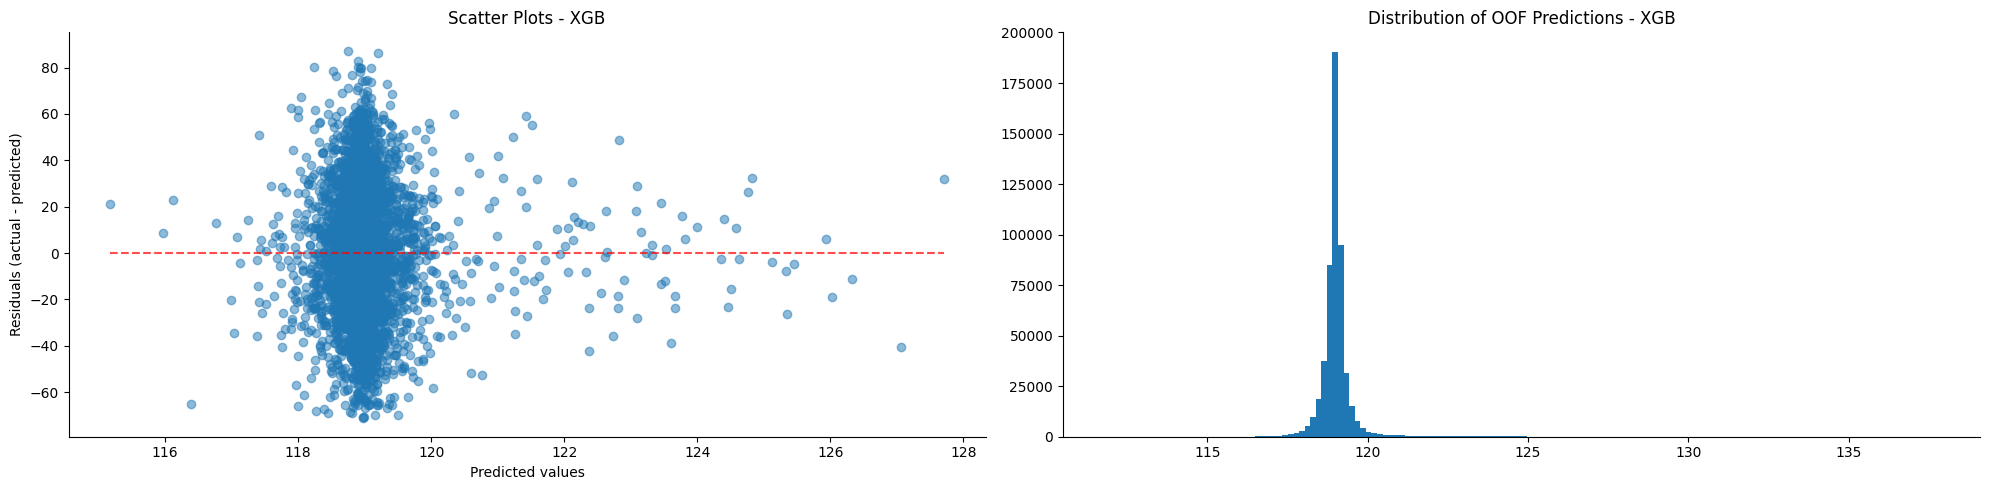

Computation Time: 1198.82 secs ##########################################################################################

[2] LGBM ████████████████████████████████████████


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4372	valid_0's l2: 698.923
[200]	valid_0's rmse: 26.4514	valid_0's l2: 699.675
[300]	valid_0's rmse: 26.4665	valid_0's l2: 700.477
Early stopping, best iteration is:
[34]	valid_0's rmse: 26.4307	valid_0's l2: 698.584
	Fold 1 RMSE: 26.430741


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4543	valid_0's l2: 699.83
[200]	valid_0's rmse: 26.4713	valid_0's l2: 700.731
[300]	valid_0's rmse: 26.482	valid_0's l2: 701.296
Early stopping, best iteration is:
[7]	valid_0's rmse: 26.4432	valid_0's l2: 699.245
	Fold 2 RMSE: 26.443246


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.5152	valid_0's l2: 703.057
[200]	valid_0's rmse: 26.5237	valid_0's l2: 703.508
[300]	valid_0's rmse: 26.5335	valid_0's l2: 704.024
Early stopping, best iteration is:
[33]	valid_0's rmse: 26.5095	valid_0's l2: 702.754
	Fold 3 RMSE: 26.509503


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4683	valid_0's l2: 700.573
[200]	valid_0's rmse: 26.4831	valid_0's l2: 701.355
[300]	valid_0's rmse: 26.4998	valid_0's l2: 702.242
Early stopping, best iteration is:
[16]	valid_0's rmse: 26.4553	valid_0's l2: 699.881
	Fold 4 RMSE: 26.455265


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.5252	valid_0's l2: 703.584
[200]	valid_0's rmse: 26.5395	valid_0's l2: 704.347
[300]	valid_0's rmse: 26.5532	valid_0's l2: 705.071
Early stopping, best iteration is:
[35]	valid_0's rmse: 26.5195	valid_0's l2: 703.284
	Fold 5 RMSE: 26.519511


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.5331	valid_0's l2: 704.006
[200]	valid_0's rmse: 26.5444	valid_0's l2: 704.605
[300]	valid_0's rmse: 26.555	valid_0's l2: 705.165
Early stopping, best iteration is:
[16]	valid_0's rmse: 26.5241	valid_0's l2: 703.526
	Fold 6 RMSE: 26.524071


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4617	valid_0's l2: 700.22
[200]	valid_0's rmse: 26.4803	valid_0's l2: 701.207
[300]	valid_0's rmse: 26.4937	valid_0's l2: 701.918
Early stopping, best iteration is:
[14]	valid_0's rmse: 26.4488	valid_0's l2: 699.54
	Fold 7 RMSE: 26.448823


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4454	valid_0's l2: 699.359
[200]	valid_0's rmse: 26.4518	valid_0's l2: 699.697
[300]	valid_0's rmse: 26.4596	valid_0's l2: 700.111
Early stopping, best iteration is:
[39]	valid_0's rmse: 26.4404	valid_0's l2: 699.095
	Fold 8 RMSE: 26.440410


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4186	valid_0's l2: 697.94
[200]	valid_0's rmse: 26.437	valid_0's l2: 698.913
[300]	valid_0's rmse: 26.4466	valid_0's l2: 699.424
Early stopping, best iteration is:
[9]	valid_0's rmse: 26.4017	valid_0's l2: 697.048
	Fold 9 RMSE: 26.401660


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 26.4246	valid_0's l2: 698.258
[200]	valid_0's rmse: 26.4385	valid_0's l2: 698.995
[300]	valid_0's rmse: 26.453	valid_0's l2: 699.76
Early stopping, best iteration is:
[19]	valid_0's rmse: 26.4152	valid_0's l2: 697.763
	Fold 10 RMSE: 26.415204
|----------------------------------------------------
|  Overall OOF RMSE: 26.458876
| Average Fold RMSE: 26.458843 ± 0.041427


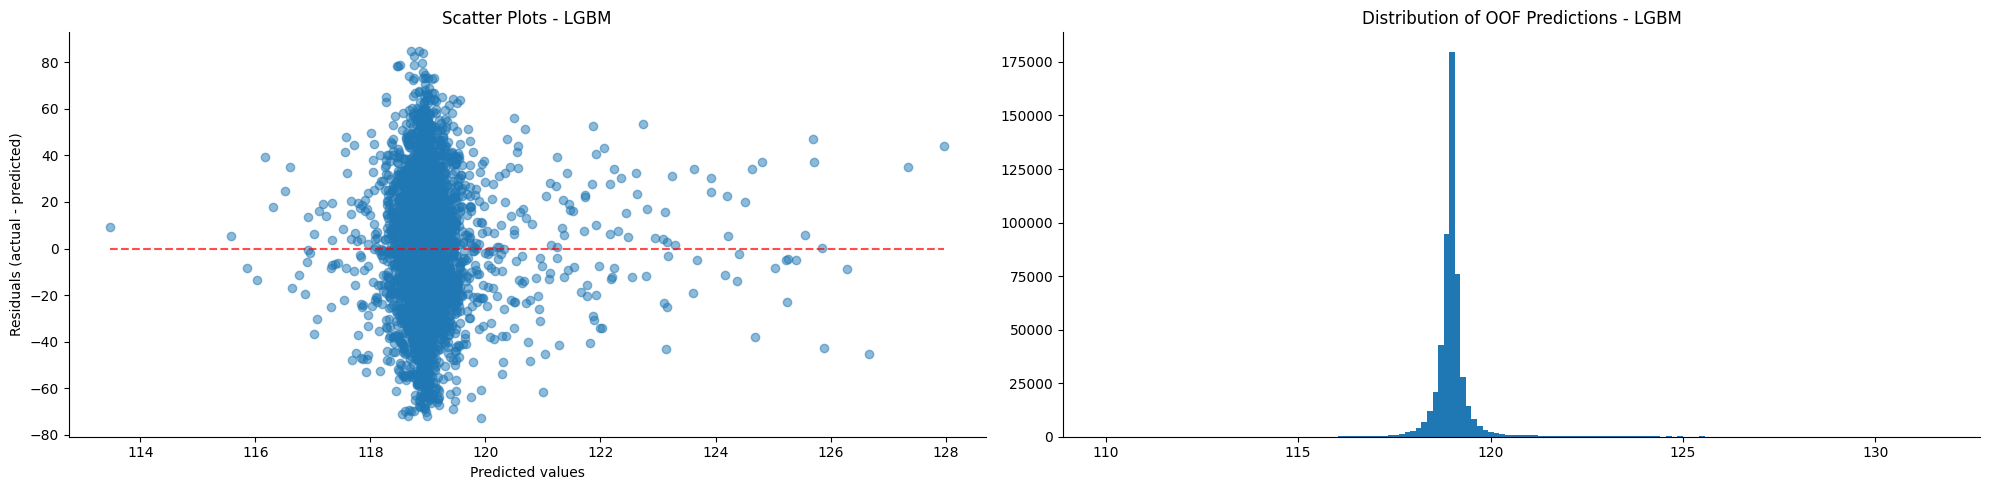

Computation Time: 640.53 secs ##########################################################################################

[3] CAT ████████████████████████████████████████


Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4708807	test: 26.4423259	best: 26.4423259 (0)	total: 589ms	remaining: 49m 4s
100:	learn: 26.4672788	test: 26.4399852	best: 26.4399852 (100)	total: 1.73s	remaining: 1m 23s
200:	learn: 26.4645145	test: 26.4383935	best: 26.4383935 (200)	total: 2.73s	remaining: 1m 5s
300:	learn: 26.4623114	test: 26.4373428	best: 26.4373428 (300)	total: 3.72s	remaining: 58.1s
400:	learn: 26.4604093	test: 26.4365490	best: 26.4365490 (400)	total: 4.7s	remaining: 53.9s
500:	learn: 26.4587750	test: 26.4359515	best: 26.4359515 (500)	total: 5.67s	remaining: 50.9s
600:	learn: 26.4572816	test: 26.4354607	best: 26.4354607 (600)	total: 6.64s	remaining: 48.6s
700:	learn: 26.4558381	test: 26.4351432	best: 26.4351432 (700)	total: 7.62s	remaining: 46.7s
800:	learn: 26.4544855	test: 26.4348863	best: 26.4348863 (800)	total: 8.6s	remaining: 45.1s
900:	learn: 26.4531624	test: 26.4346640	best: 26.4346640 (897)	total: 9.57s	remaining: 43.5s
1000:	learn: 26.4519418	test: 26.4344908	best: 26.4344879 (995)	total: 10.

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4702195	test: 26.4481750	best: 26.4481750 (0)	total: 18.7ms	remaining: 1m 33s
100:	learn: 26.4665394	test: 26.4462447	best: 26.4462447 (100)	total: 1.15s	remaining: 55.6s
200:	learn: 26.4637340	test: 26.4449880	best: 26.4449880 (200)	total: 2.12s	remaining: 50.7s
300:	learn: 26.4614411	test: 26.4441944	best: 26.4441944 (300)	total: 3.1s	remaining: 48.4s
400:	learn: 26.4595005	test: 26.4436577	best: 26.4436577 (400)	total: 4.07s	remaining: 46.7s
500:	learn: 26.4577969	test: 26.4433431	best: 26.4433431 (500)	total: 5.05s	remaining: 45.3s
600:	learn: 26.4562983	test: 26.4431123	best: 26.4431123 (600)	total: 6.02s	remaining: 44.1s
700:	learn: 26.4548394	test: 26.4429882	best: 26.4429853 (697)	total: 6.93s	remaining: 42.5s
800:	learn: 26.4534393	test: 26.4428799	best: 26.4428641 (776)	total: 7.92s	remaining: 41.5s
900:	learn: 26.4520815	test: 26.4428165	best: 26.4428165 (900)	total: 8.88s	remaining: 40.4s
1000:	learn: 26.4507519	test: 26.4427977	best: 26.4427761 (966)	total: 9.

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4619294	test: 26.5227071	best: 26.5227071 (0)	total: 20ms	remaining: 1m 40s
100:	learn: 26.4583750	test: 26.5202413	best: 26.5202413 (100)	total: 1.15s	remaining: 56s
200:	learn: 26.4556317	test: 26.5185536	best: 26.5185536 (200)	total: 2.12s	remaining: 50.6s
300:	learn: 26.4533919	test: 26.5173622	best: 26.5173622 (300)	total: 3.09s	remaining: 48.3s
400:	learn: 26.4515879	test: 26.5166025	best: 26.5166025 (400)	total: 4.06s	remaining: 46.5s
500:	learn: 26.4499594	test: 26.5160240	best: 26.5160240 (500)	total: 5.01s	remaining: 45s
600:	learn: 26.4485027	test: 26.5156153	best: 26.5156153 (600)	total: 5.97s	remaining: 43.7s
700:	learn: 26.4470934	test: 26.5153333	best: 26.5153333 (700)	total: 6.92s	remaining: 42.4s
800:	learn: 26.4457622	test: 26.5150743	best: 26.5150656 (798)	total: 7.89s	remaining: 41.4s
900:	learn: 26.4444476	test: 26.5148786	best: 26.5148786 (899)	total: 8.87s	remaining: 40.3s
1000:	learn: 26.4431932	test: 26.5147059	best: 26.5147059 (1000)	total: 9.84s	

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4684974	test: 26.4637064	best: 26.4637064 (0)	total: 16.8ms	remaining: 1m 24s
100:	learn: 26.4650502	test: 26.4612350	best: 26.4612350 (100)	total: 1.04s	remaining: 50.3s
200:	learn: 26.4623537	test: 26.4594138	best: 26.4594138 (200)	total: 1.94s	remaining: 46.4s
300:	learn: 26.4601991	test: 26.4582500	best: 26.4582500 (300)	total: 2.91s	remaining: 45.4s
400:	learn: 26.4583789	test: 26.4574540	best: 26.4574540 (400)	total: 3.89s	remaining: 44.7s
500:	learn: 26.4567701	test: 26.4568987	best: 26.4568987 (500)	total: 4.79s	remaining: 43s
600:	learn: 26.4552701	test: 26.4563897	best: 26.4563897 (600)	total: 5.7s	remaining: 41.7s
700:	learn: 26.4538945	test: 26.4561128	best: 26.4561041 (698)	total: 6.58s	remaining: 40.4s
800:	learn: 26.4525611	test: 26.4558834	best: 26.4558820 (799)	total: 7.46s	remaining: 39.1s
900:	learn: 26.4512725	test: 26.4556916	best: 26.4556887 (898)	total: 8.36s	remaining: 38s
1000:	learn: 26.4500364	test: 26.4555820	best: 26.4555820 (999)	total: 9.24s	

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4610644	test: 26.5304442	best: 26.5304442 (0)	total: 19.6ms	remaining: 1m 37s
100:	learn: 26.4576419	test: 26.5276640	best: 26.5276640 (100)	total: 1.13s	remaining: 54.8s
200:	learn: 26.4549639	test: 26.5257897	best: 26.5257897 (200)	total: 2.09s	remaining: 50s
300:	learn: 26.4528266	test: 26.5245411	best: 26.5245411 (300)	total: 3.07s	remaining: 47.9s
400:	learn: 26.4509803	test: 26.5237025	best: 26.5237025 (400)	total: 4.03s	remaining: 46.2s
500:	learn: 26.4493313	test: 26.5231083	best: 26.5231083 (500)	total: 5.01s	remaining: 45s
600:	learn: 26.4478566	test: 26.5227875	best: 26.5227861 (596)	total: 5.99s	remaining: 43.8s
700:	learn: 26.4464510	test: 26.5225070	best: 26.5225070 (699)	total: 6.97s	remaining: 42.8s
800:	learn: 26.4451301	test: 26.5222782	best: 26.5222782 (800)	total: 7.95s	remaining: 41.7s
900:	learn: 26.4438347	test: 26.5221070	best: 26.5221070 (900)	total: 8.9s	remaining: 40.5s
1000:	learn: 26.4425611	test: 26.5219517	best: 26.5219473 (996)	total: 9.79s	

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4608517	test: 26.5323857	best: 26.5323857 (0)	total: 19.8ms	remaining: 1m 38s
100:	learn: 26.4574343	test: 26.5295870	best: 26.5295870 (100)	total: 1.16s	remaining: 56.1s
200:	learn: 26.4547652	test: 26.5276956	best: 26.5276956 (200)	total: 2.15s	remaining: 51.3s
300:	learn: 26.4525625	test: 26.5263479	best: 26.5263479 (300)	total: 3.13s	remaining: 48.9s
400:	learn: 26.4506931	test: 26.5255337	best: 26.5255337 (400)	total: 4.13s	remaining: 47.3s
500:	learn: 26.4490902	test: 26.5249454	best: 26.5249454 (499)	total: 5.07s	remaining: 45.6s
600:	learn: 26.4475539	test: 26.5244347	best: 26.5244347 (600)	total: 6.03s	remaining: 44.1s
700:	learn: 26.4461240	test: 26.5241326	best: 26.5241283 (699)	total: 6.97s	remaining: 42.7s
800:	learn: 26.4447864	test: 26.5239312	best: 26.5239312 (792)	total: 7.91s	remaining: 41.5s
900:	learn: 26.4434371	test: 26.5236967	best: 26.5236967 (900)	total: 8.88s	remaining: 40.4s
1000:	learn: 26.4421314	test: 26.5235140	best: 26.5235039 (995)	total: 9

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4694470	test: 26.4552228	best: 26.4552228 (0)	total: 18.6ms	remaining: 1m 33s
100:	learn: 26.4658193	test: 26.4530016	best: 26.4530016 (100)	total: 1.14s	remaining: 55.2s
200:	learn: 26.4630370	test: 26.4515793	best: 26.4515793 (200)	total: 2.13s	remaining: 50.7s
300:	learn: 26.4608363	test: 26.4506071	best: 26.4506071 (300)	total: 3.13s	remaining: 48.8s
400:	learn: 26.4589290	test: 26.4499680	best: 26.4499680 (400)	total: 4.11s	remaining: 47.1s
500:	learn: 26.4572548	test: 26.4495223	best: 26.4495223 (500)	total: 5.09s	remaining: 45.7s
600:	learn: 26.4557280	test: 26.4492539	best: 26.4492539 (600)	total: 6.08s	remaining: 44.5s
700:	learn: 26.4542703	test: 26.4490693	best: 26.4490693 (700)	total: 7.08s	remaining: 43.4s
800:	learn: 26.4528702	test: 26.4488255	best: 26.4488255 (800)	total: 8.05s	remaining: 42.2s
900:	learn: 26.4515547	test: 26.4487519	best: 26.4487490 (888)	total: 8.99s	remaining: 40.9s
1000:	learn: 26.4502443	test: 26.4485499	best: 26.4485413 (998)	total: 9

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4696226	test: 26.4535281	best: 26.4535281 (0)	total: 20.8ms	remaining: 1m 44s
100:	learn: 26.4661768	test: 26.4509086	best: 26.4509086 (100)	total: 1.15s	remaining: 55.6s
200:	learn: 26.4634586	test: 26.4490174	best: 26.4490174 (200)	total: 2.11s	remaining: 50.5s
300:	learn: 26.4612580	test: 26.4476843	best: 26.4476843 (300)	total: 3.09s	remaining: 48.3s
400:	learn: 26.4594801	test: 26.4468331	best: 26.4468331 (399)	total: 4.07s	remaining: 46.7s
500:	learn: 26.4579406	test: 26.4463079	best: 26.4463079 (500)	total: 5.08s	remaining: 45.6s
600:	learn: 26.4564344	test: 26.4457640	best: 26.4457582 (598)	total: 6.03s	remaining: 44.1s
700:	learn: 26.4550729	test: 26.4453730	best: 26.4453730 (700)	total: 6.98s	remaining: 42.8s
800:	learn: 26.4537523	test: 26.4450253	best: 26.4450224 (798)	total: 7.92s	remaining: 41.5s
900:	learn: 26.4524394	test: 26.4447843	best: 26.4447843 (900)	total: 8.89s	remaining: 40.4s
1000:	learn: 26.4511829	test: 26.4445159	best: 26.4445159 (1000)	total: 

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4746731	test: 26.4080147	best: 26.4080147 (0)	total: 19.2ms	remaining: 1m 35s
100:	learn: 26.4710781	test: 26.4057837	best: 26.4057837 (100)	total: 1.16s	remaining: 56.2s
200:	learn: 26.4682400	test: 26.4043358	best: 26.4043358 (200)	total: 2.17s	remaining: 51.9s
300:	learn: 26.4659603	test: 26.4034081	best: 26.4034066 (299)	total: 3.19s	remaining: 49.8s
400:	learn: 26.4640815	test: 26.4028632	best: 26.4028632 (400)	total: 4.19s	remaining: 48.1s
500:	learn: 26.4624064	test: 26.4025699	best: 26.4025699 (499)	total: 5.17s	remaining: 46.4s
600:	learn: 26.4608388	test: 26.4023011	best: 26.4023011 (600)	total: 6.17s	remaining: 45.1s
700:	learn: 26.4593443	test: 26.4021551	best: 26.4021363 (695)	total: 7.18s	remaining: 44.1s
800:	learn: 26.4578945	test: 26.4020496	best: 26.4020236 (786)	total: 8.1s	remaining: 42.5s
900:	learn: 26.4565254	test: 26.4020063	best: 26.4019947 (891)	total: 9.01s	remaining: 41s
1000:	learn: 26.4552523	test: 26.4019860	best: 26.4019773 (950)	total: 9.9s

Target Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

0:	learn: 26.4729359	test: 26.4237043	best: 26.4237043 (0)	total: 18.5ms	remaining: 1m 32s
100:	learn: 26.4693791	test: 26.4212465	best: 26.4212465 (100)	total: 1.13s	remaining: 54.7s
200:	learn: 26.4666061	test: 26.4194557	best: 26.4194557 (200)	total: 2.13s	remaining: 51s
300:	learn: 26.4643596	test: 26.4183075	best: 26.4183075 (300)	total: 3.13s	remaining: 48.9s
400:	learn: 26.4625256	test: 26.4175059	best: 26.4175059 (400)	total: 4.13s	remaining: 47.3s
500:	learn: 26.4608927	test: 26.4169425	best: 26.4169425 (500)	total: 5.12s	remaining: 46s
600:	learn: 26.4594109	test: 26.4165294	best: 26.4165294 (600)	total: 6.11s	remaining: 44.7s
700:	learn: 26.4580060	test: 26.4162377	best: 26.4162377 (700)	total: 7.09s	remaining: 43.5s
800:	learn: 26.4566843	test: 26.4159835	best: 26.4159835 (799)	total: 8.05s	remaining: 42.2s
900:	learn: 26.4553908	test: 26.4157870	best: 26.4157870 (896)	total: 8.93s	remaining: 40.6s
1000:	learn: 26.4541472	test: 26.4156469	best: 26.4156455 (989)	total: 9.84s

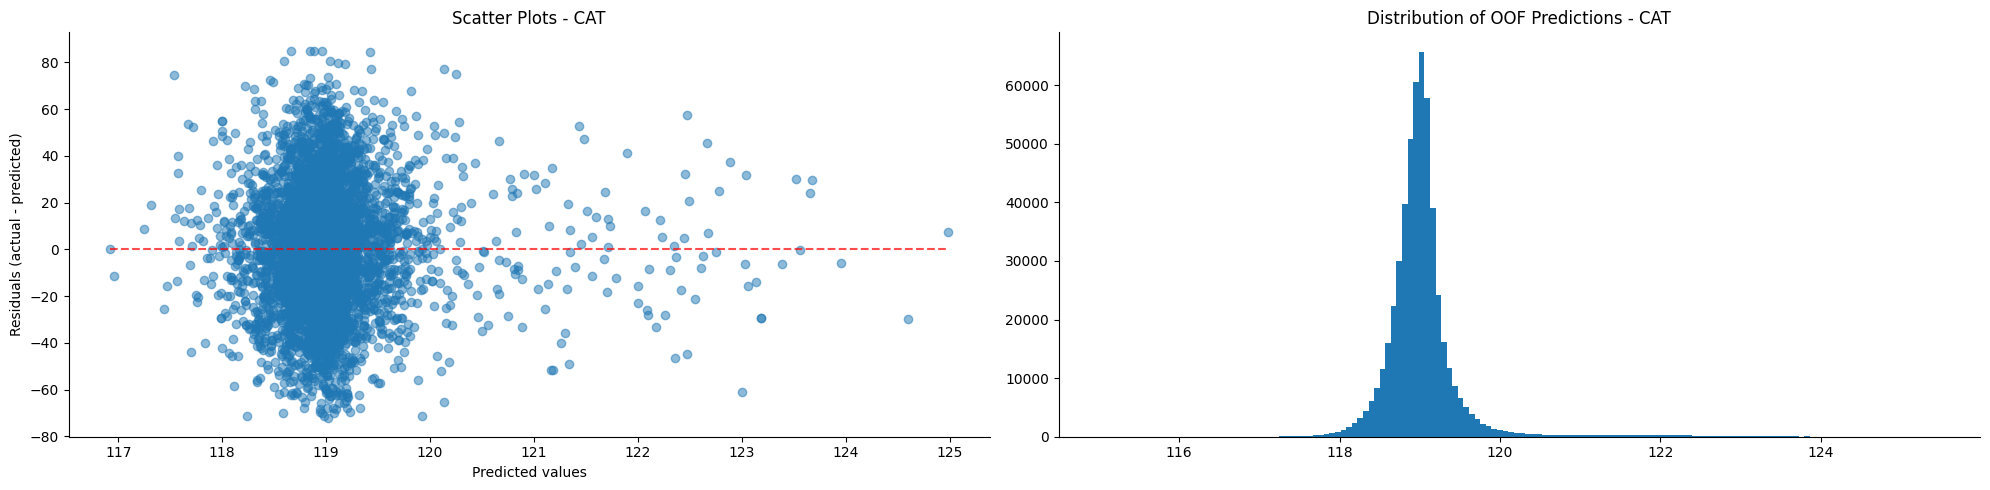

Computation Time: 817.60 secs ##########################################################################################


In [20]:
## -- DEFINE TRAINING PARAMETERS -- ##
## -----------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

oof_final_df = pd.DataFrame()
test_final_df = pd.DataFrame()

MODELS_FIT = {}
FOLDS = 10
STOP = 300
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED+_add)

## -- Split data --
X = train.drop(TARGET, axis=1)
y = train[TARGET]

## -- INITIATE TRAINING -- ##
## -----------------------------------------------------------------------
for i, (name, model) in tqdm(enumerate(models.items(), 1), total=NUM_MODELS, desc="TRAINING MODELS"):
    print(f"\n{COLOR}[{i}] {name} {'█'*40}{RESET}")
    tik = time()

    oof_preds   = np.zeros(len(X))
    test_preds  = np.zeros(len(test))
    fold_Scores = []

    # model = make_pipeline((RobustScaler(), SKEWED_COLS), model)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        X_train_enc = X_train_fold.copy()
        X_val_enc   = X_val_fold.copy()
        test_enc    = test.copy()

        # for skew in FEATURES:
        #     # scaler = RobustScaler()
        #     scaler = QuantileTransformer(n_quantiles=10, output_distribution='uniform', random_state=SEED)
        #     X_train_enc[f"tr_{skew}"] = scaler.fit_transform(X_train_enc[[skew]])
        #     X_val_enc[f"tr_{skew}"] = scaler.transform(X_val_enc[[skew]])
        #     test_enc[f"tr_{skew}"] = scaler.transform(test_enc[[skew]])

        ## -- COUNT ENCODING -- ##
        # for col in tqdm(TE_columns, desc="Count Encoding features", leave=False):
        #     CE_enc = ce.CountEncoder(cols=[col]).fit(X_train_enc[col], y_train_fold)
        #     CE_col = f"CE_{col}"
        #     X_train_enc[CE_col] = CE_enc.transform(X_train_enc[[col]]).copy()
        #     X_val_enc[CE_col] = CE_enc.transform(X_val_enc[[col]]).copy()
        #     test_enc[CE_col] = CE_enc.transform(test_enc[[col]]).copy()

        ## -- TARGET ENCODING -- ##
        for col in tqdm(TE+orig_TE, desc="Target Encoding", leave=False):
            if USE_cud == 'cuda': # GPU
                TE_enc = cuTE(n_folds=10, smooth=5, split_method='random')
            else:  # CPU
                TE_enc = ce.TargetEncoder(cols=[col], smoothing=5)
            n = f"TE_{col}"
            X_train_enc[n] = TE_enc.fit_transform(X_train_enc[col], y_train_fold).astype('float32')
            X_val_enc[n]   = TE_enc.transform(X_val_enc[col]).astype('float32')
            test_enc[n]    = TE_enc.transform(test_enc[col]).astype('float32')

            # X_train_enc = X_train_enc.drop(col, axis=1)
            # X_val_enc   = X_val_enc.drop(col, axis=1)
            # test_enc    = test_enc.drop(col, axis=1)

            gc.collect()

        if name == 'XGB':
            model.fit(
                    X_train_enc, y_train_fold,
                    eval_set = [(X_val_enc, y_val_fold)],
                    verbose  = 100,
                )
            y_fold_pred = model.predict(X_val_enc, iteration_range=(0, model.best_iteration+1))
            oof_preds[val_idx] = y_fold_pred
            test_preds += model.predict(test_enc, iteration_range=(0, model.best_iteration+1)) / FOLDS

        elif name == 'LGBM':
            model.fit(
                    X_train_enc, y_train_fold, eval_metric='rmse',
                    eval_set  = [(X_val_enc, y_val_fold)],
                    callbacks = [
                        lgb.early_stopping(stopping_rounds=STOP),
                        lgb.log_evaluation(period=100)
                      ]
                )
            y_fold_pred = model.predict(X_val_enc, num_iteration=int(model.best_iteration_))
            oof_preds[val_idx] = y_fold_pred
            test_preds += model.predict(test_enc, num_iteration=int(model.best_iteration_)) / FOLDS

        elif name == 'CAT':
            model.fit(
                    X_train_enc, y_train_fold,
                    eval_set = [(X_val_enc, y_val_fold)],
                    early_stopping_rounds = STOP,
                    use_best_model = True, verbose=100,
                )
            y_fold_pred = model.predict(X_val_enc)
            oof_preds[val_idx] = y_fold_pred
            test_preds += model.predict(test_enc) / FOLDS

        else:
            model.fit(X_train_enc, y_train_fold)

            y_fold_pred = model.predict(X_val_enc)
            oof_preds[val_idx] = y_fold_pred
            test_preds += model.predict(test_enc) / FOLDS

        ## -- Compute RMSE for validation fold
        fold_rmse = rmse(y_val_fold, y_fold_pred)
        fold_Scores.append(fold_rmse)

        print(f"\tFold {fold} RMSE: {fold_rmse:.6f}")

        gc.collect()

    ## -- After all folds --
    overall_RMSE = rmse(y, oof_preds)
    print(f"|{'-'*52}")
    print(f"{COLOR}|  Overall OOF RMSE: {overall_RMSE:.6f}")
    print(f"| Average Fold RMSE: {np.mean(fold_Scores):.6f} ± {np.std(fold_Scores):.6f}{RESET}")

    ## -- Plot predictions errors --
    fig, axs = plt.subplots(1, 2, figsize = (20, 5))
    display = PredictionErrorDisplay.from_predictions(
                    y, oof_preds, ax = axs[0],
                    # kind = "actual_vs_predicted",
                    subsample = 5000,
                    scatter_kwargs = {"alpha": 0.5},
                    line_kwargs = {'color': 'r'},
            )
    axs[0].set_title(f"Scatter Plots - {name}")
    ## ---------------------------------------------------------------------
    plt.hist(oof_preds, bins=150)
    axs[1].set_title(f"Distribution of OOF Predictions - {name}")
    ## ---------------------------------------------------------------------
    for ax in axs:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

    oof_final_df[name]  = oof_preds
    test_final_df[name] = test_preds
    MODELS_FIT[name]    = model

    tok = time()
    tiktok = tok-tik
    print(f"Computation Time: {tiktok:.2f} secs {'#'*90}")

In [21]:
print(test_final_df.head())
oof_final_df.shape, test_final_df.shape

          XGB        LGBM         CAT
0  118.473372  117.299809  118.313836
1  118.223393  117.003560  118.162304
2  119.044718  117.758025  118.625062
3  120.823106  119.429257  118.887983
4  118.757269  117.470374  118.175990


((524164, 3), (174722, 3))

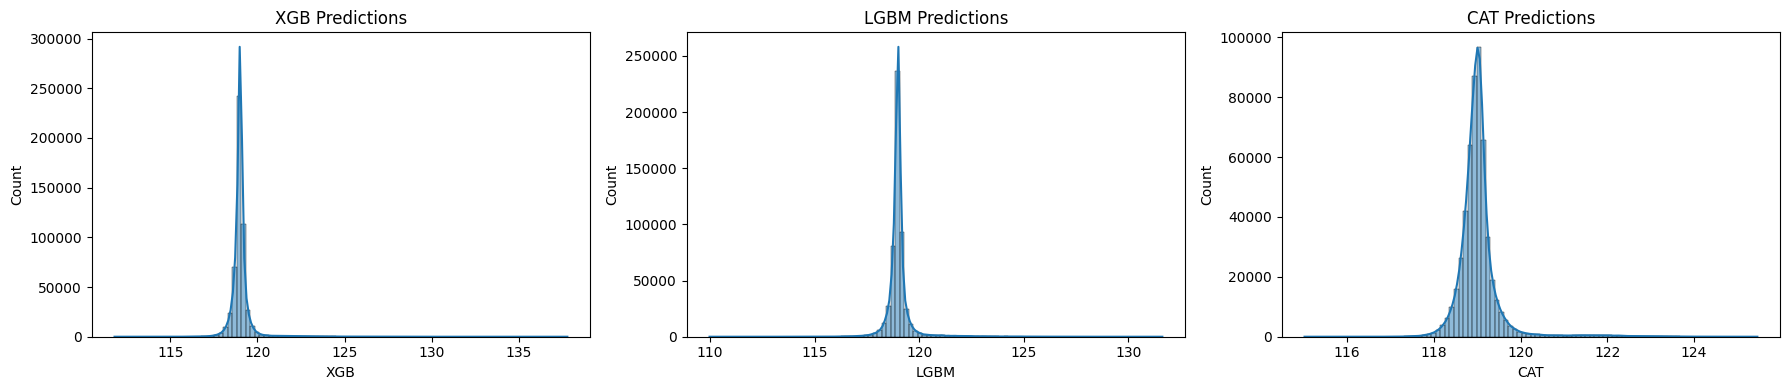

In [22]:
plt.figure(figsize=(18, 4))
for i, c in enumerate(test_final_df.columns, 1):
    plt.subplot(1, NUM_MODELS, i)
    sns.histplot(oof_final_df[c], kde=True, bins=100)
    plt.title(f"{c} Predictions")

plt.tight_layout()
plt.show()

In [23]:
## -- Export OOF & PREDICTIONS files -- ##
score = '45xxxx'
for df in (oof_final_df, test_final_df):
    df.columns = [f"{c}_{score}" for c in ['XGB','LGBM','CAT']] # 'XGB','LGBM','CAT','HGB', 'RF'

oof_final_df.to_parquet(f"XLC{score}_oof.parquet", index=False)
test_final_df.to_parquet(f"XLC{score}_pred.parquet", index=False)

In [24]:
X_val_enc.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,orig_RhythmScore,orig_AudioLoudness,orig_VocalContent,orig_AcousticQuality,orig_InstrumentalScore,orig_LivePerformanceLikelihood,orig_MoodScore,orig_TrackDurationMs,orig_Energy,qt_rhythmscore,de_rhythmscore,qt_audioloudness,de_audioloudness,qt_vocalcontent,de_vocalcontent,qt_acousticquality,de_acousticquality,qt_instrumentalscore,de_instrumentalscore,qt_liveperformancelikelihood,de_liveperformancelikelihood,qt_moodscore,de_moodscore,qt_trackdurationms,de_trackdurationms,qt_energy,de_energy,AudioLoudness-RhythmScore,RhythmScore-VocalContent,AcousticQuality-RhythmScore,InstrumentalScore-RhythmScore,LivePerformanceLikelihood-RhythmScore,MoodScore-RhythmScore,RhythmScore-TrackDurationMs,Energy-RhythmScore,AudioLoudness-VocalContent,AcousticQuality-AudioLoudness,AudioLoudness-InstrumentalScore,AudioLoudness-LivePerformanceLikelihood,AudioLoudness-MoodScore,AudioLoudness-TrackDurationMs,AudioLoudness-Energy,AcousticQuality-VocalContent,InstrumentalScore-VocalContent,LivePerformanceLikelihood-VocalContent,MoodScore-VocalContent,TrackDurationMs-VocalContent,Energy-VocalContent,AcousticQuality-InstrumentalScore,AcousticQuality-LivePerformanceLikelihood,AcousticQuality-MoodScore,AcousticQuality-TrackDurationMs,AcousticQuality-Energy,InstrumentalScore-LivePerformanceLikelihood,InstrumentalScore-MoodScore,InstrumentalScore-TrackDurationMs,Energy-InstrumentalScore,LivePerformanceLikelihood-MoodScore,LivePerformanceLikelihood-TrackDurationMs,Energy-LivePerformanceLikelihood,MoodScore-TrackDurationMs,Energy-MoodScore,Energy-TrackDurationMs,qt_orig_rhythmscore,de_orig_rhythmscore,qt_orig_audioloudness,de_orig_audioloudness,qt_orig_vocalcontent,de_orig_vocalcontent,qt_orig_acousticquality,de_orig_acousticquality,qt_orig_instrumentalscore,de_orig_instrumentalscore,qt_orig_liveperformancelikelihood,de_orig_liveperformancelikelihood,qt_orig_moodscore,de_orig_moodscore,qt_orig_trackdurationms,de_orig_trackdurationms,qt_orig_energy,de_orig_energy,orig_AudioLoudness-orig_RhythmScore,orig_RhythmScore-orig_VocalContent,orig_AcousticQuality-orig_RhythmScore,orig_InstrumentalScore-orig_RhythmScore,orig_LivePerformanceLikelihood-orig_RhythmScore,orig_MoodScore-orig_RhythmScore,orig_RhythmScore-orig_TrackDurationMs,orig_Energy-orig_RhythmScore,orig_AudioLoudness-orig_VocalContent,orig_AcousticQuality-orig_AudioLoudness,orig_AudioLoudness-orig_InstrumentalScore,orig_AudioLoudness-orig_LivePerformanceLikelihood,orig_AudioLoudness-orig_MoodScore,orig_AudioLoudness-orig_TrackDurationMs,orig_AudioLoudness-orig_Energy,orig_AcousticQuality-orig_VocalContent,orig_InstrumentalScore-orig_VocalContent,orig_LivePerformanceLikelihood-orig_VocalContent,orig_MoodScore-orig_VocalContent,orig_TrackDurationMs-orig_VocalContent,orig_Energy-orig_VocalContent,orig_AcousticQuality-orig_InstrumentalScore,orig_AcousticQuality-orig_LivePerformanceLikelihood,orig_AcousticQuality-orig_MoodScore,orig_AcousticQuality-orig_TrackDurationMs,orig_AcousticQuality-orig_Energy,orig_InstrumentalScore-orig_LivePerformanceLikelihood,orig_InstrumentalScore-orig_MoodScore,orig_InstrumentalScore-orig_TrackDurationMs,orig_Energy-orig_InstrumentalScore,orig_LivePerformanceLikelihood-orig_MoodScore,orig_LivePerformanceLikelihood-orig_TrackDurationMs,orig_Energy-orig_LivePerformanceLikelihood,orig_MoodScore-orig_TrackDurationMs,orig_Energy-orig_MoodScore,orig_Energy-orig_TrackDurationMs,TE_AudioLoudness-RhythmScore,TE_RhythmScore-VocalContent,TE_AcousticQuality-RhythmScore,TE_InstrumentalScore-RhythmScore,TE_LivePerformanceLikelihood-RhythmScore,TE_MoodScore-RhythmScore,TE_RhythmScore-TrackDurationMs,TE_Energy-RhythmScore,TE_AudioLoudness-VocalContent,TE_AcousticQuality-AudioLoudness,TE_AudioLoudness-InstrumentalScore,TE_AudioLoudness-LivePerformanceLikelihood,TE_AudioLoudness-MoodScore,TE_AudioLoudness-TrackDurationMs,TE_AudioLoudness-Energy,TE_AcousticQuality-VocalCon

In [25]:
# submit["BeatsPerMinute"] = test_final_df
# submit.to_csv("xgb26-463287.csv", index=False)
# submit.head()

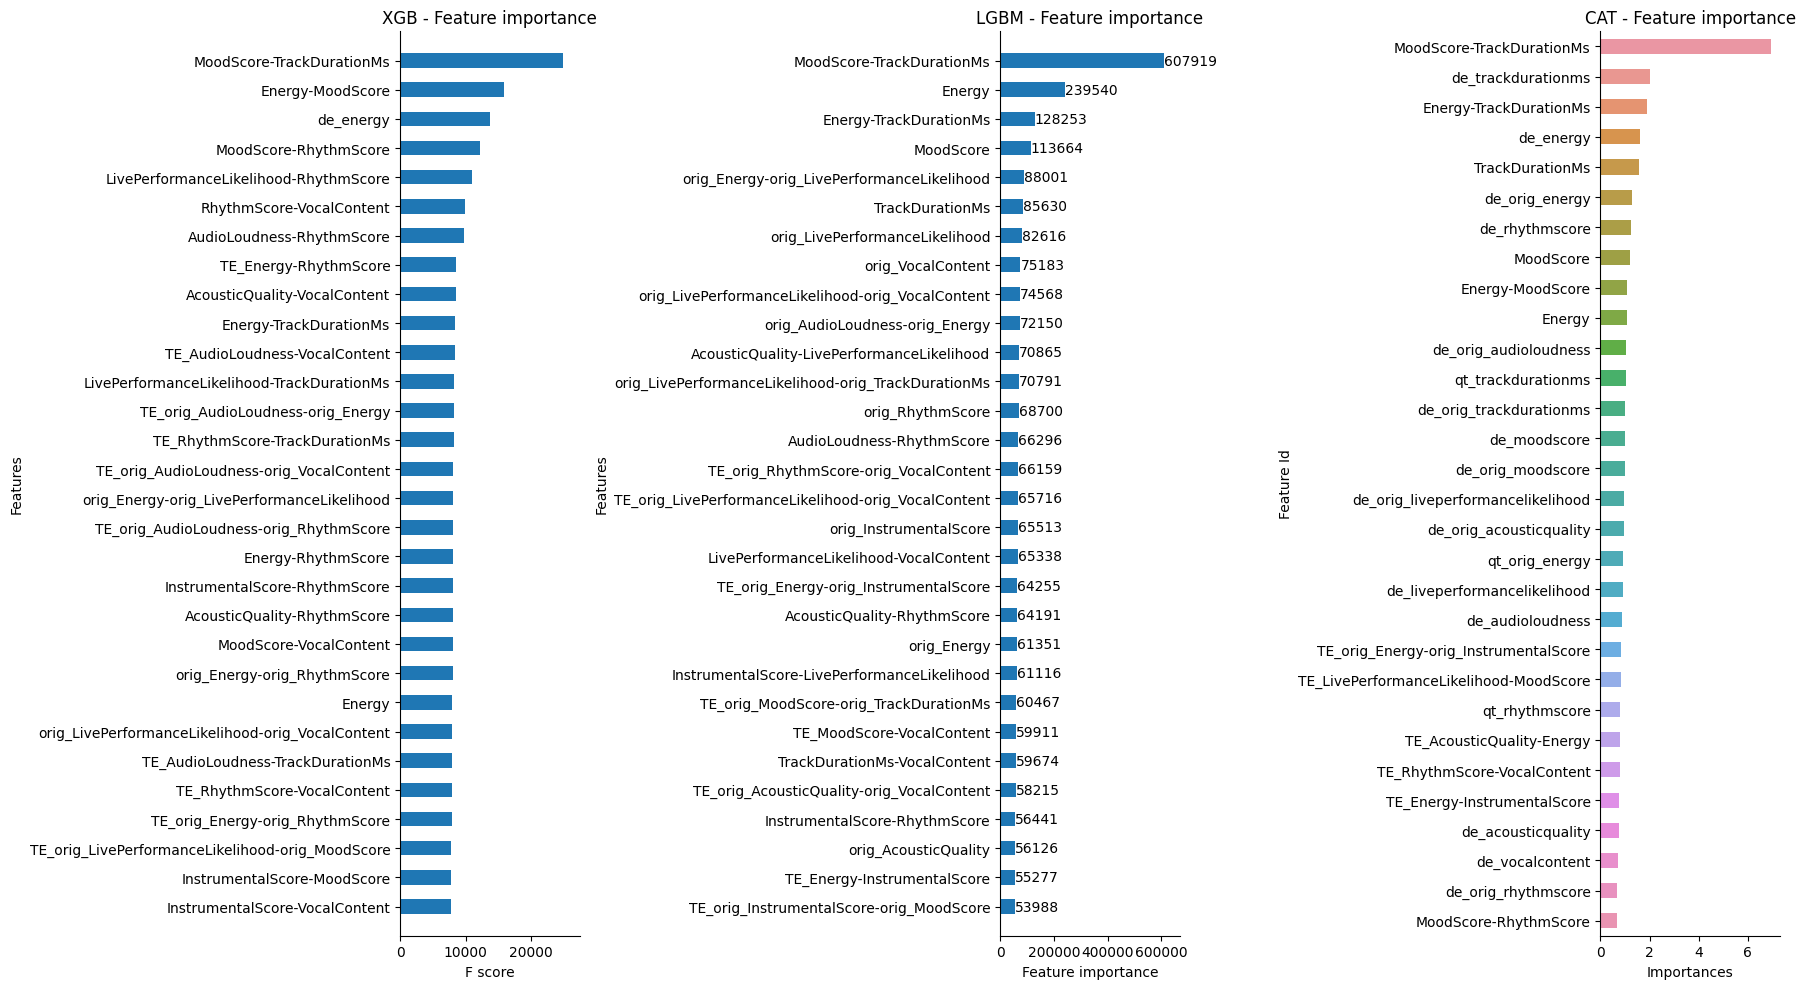

In [26]:
## -- PLOT FEATURES IMPORTANCES -- 
MAX_ = 30
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
## -- XGBoost -- 
xgb.plot_importance(MODELS_FIT['XGB'], importance_type='gain',
                    ax=axs[0], grid=False, height=.5, show_values=False,
                    max_num_features=MAX_, title="XGB - Feature importance")

## -- LightGBM -- 
lgb.plot_importance(MODELS_FIT['LGBM'], importance_type='gain',
                    ax=axs[1], grid=False, height=.5, precision=0,
                    max_num_features=MAX_, title="LGBM - Feature importance")

## -- CatBoost -- 
cat_imp_df = MODELS_FIT['CAT'].get_feature_importance(prettified=True)
sns.barplot(data=cat_imp_df.iloc[:MAX_], x='Importances', y='Feature Id', width=.5, ax=axs[2])
axs[2].set_title('CAT - Feature importance')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

 99%|===================| 1983/2000 [01:26<00:00]       

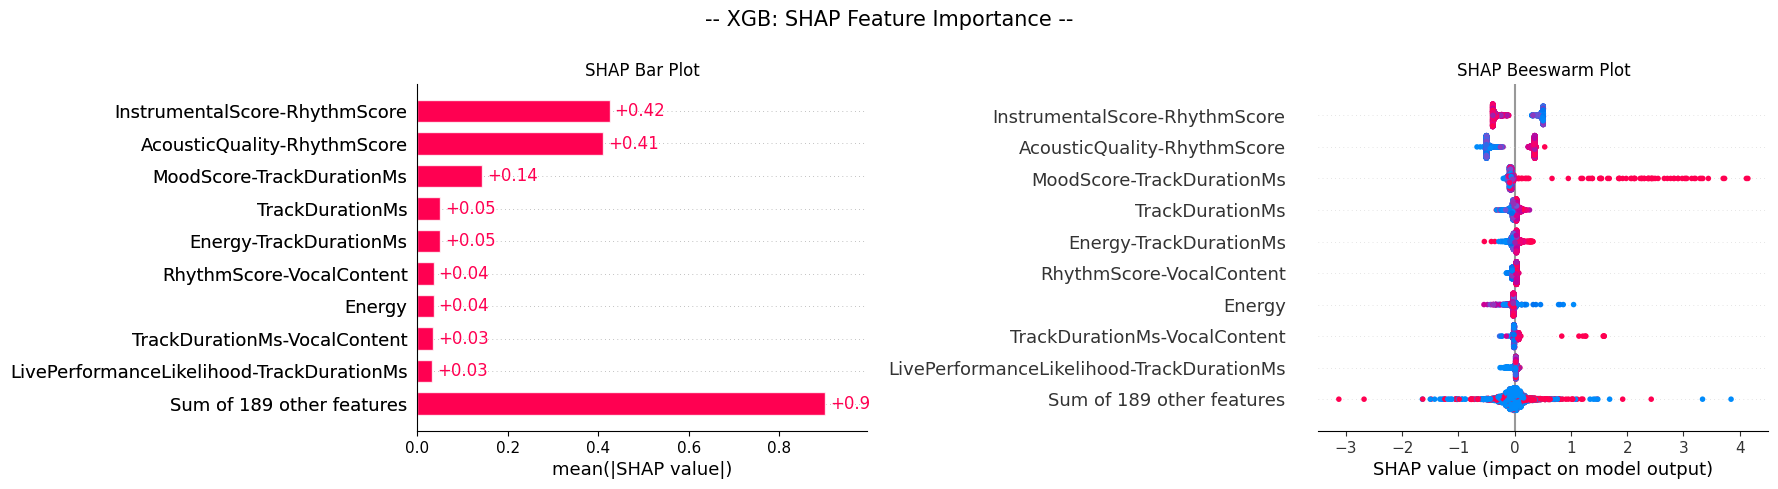

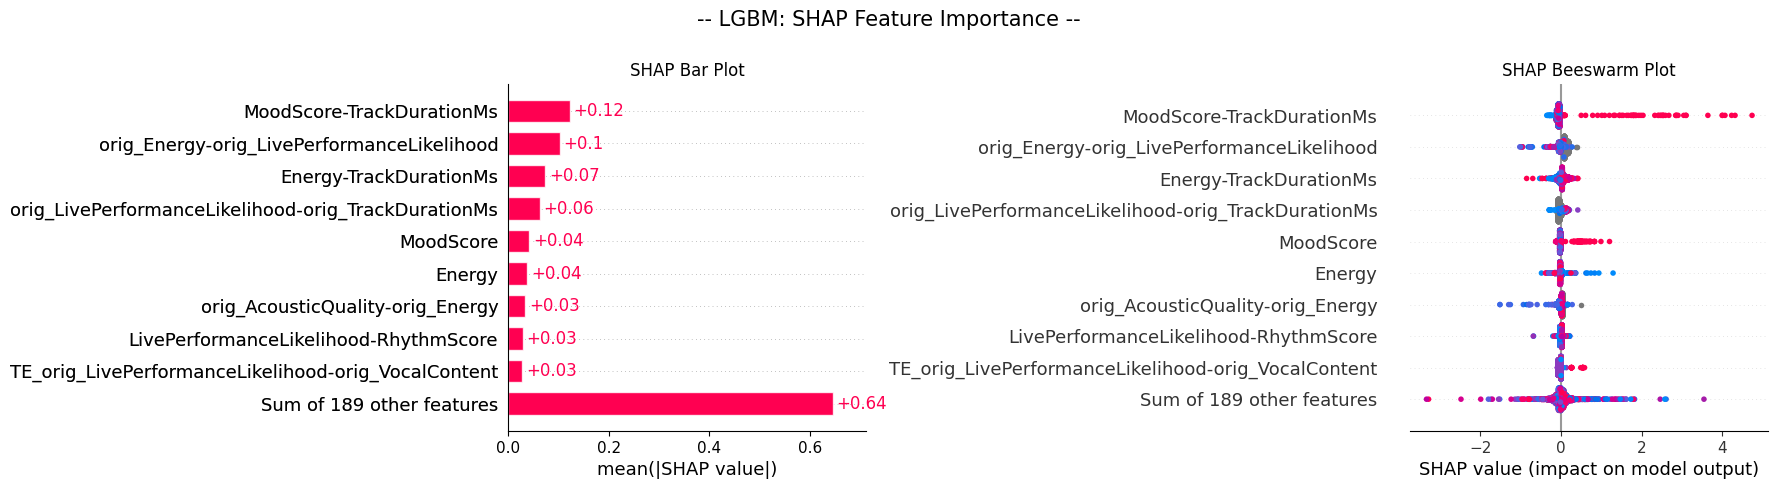

100%|===================| 1995/2000 [05:59<00:00]       

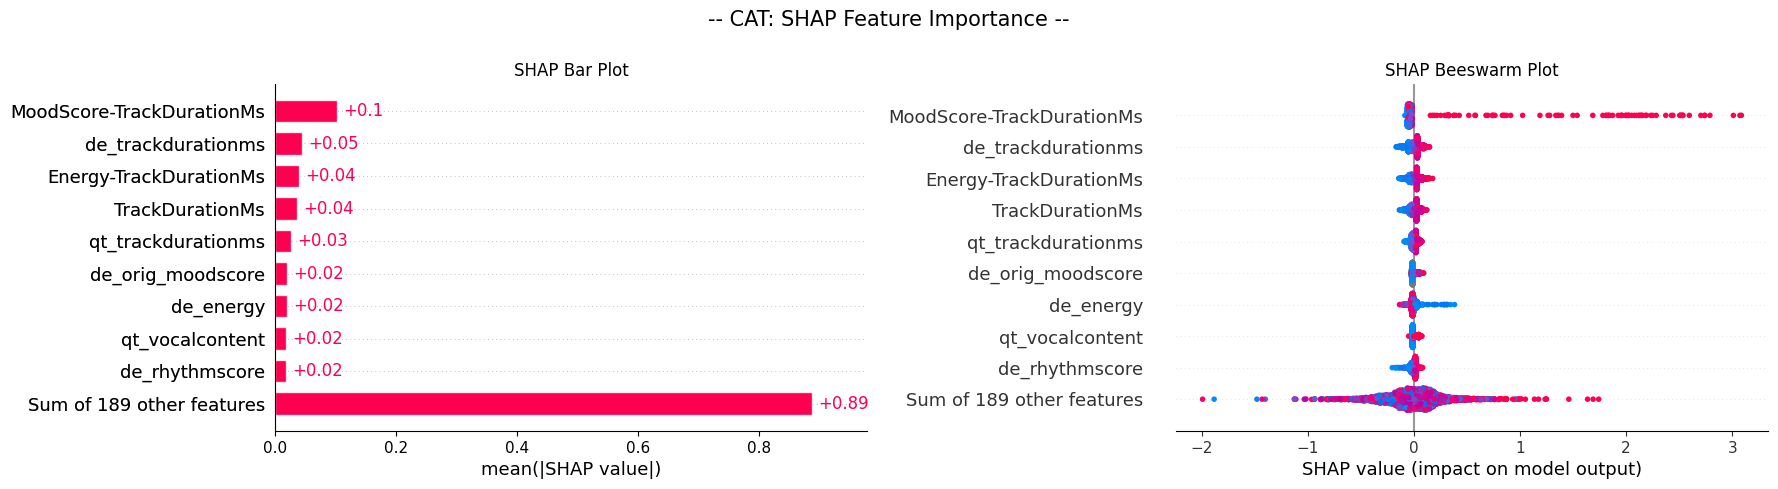

In [27]:
## -- Plot SHAP values --
for i, (name, model) in enumerate(MODELS_FIT.items()):
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    
    explainer = shap.TreeExplainer(model, X_train_enc)
    shap_values = explainer(X_val_enc.sample(2000))
    
    # Bar plot on first subplot
    shap.plots.bar(shap_values, show=False, ax=axs[0])
    axs[0].set_title("SHAP Bar Plot")
    
    # Beeswarm plot on second subplot
    shap.plots.beeswarm(shap_values, show=False, ax=axs[1], color_bar=False, plot_size=None)
    axs[1].set_title("SHAP Beeswarm Plot") 
    
    # Add suptitle and adjust layout
    fig.suptitle(f"-- {name}: SHAP Feature Importance --", fontsize=15)
    fig.tight_layout(pad=1.5) 
    
    plt.show()
    print("\n")

In [28]:
# ## -- GPU FORWARD FEATURE SELECTION -- ##
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# ADD  = []
# best_rmse = 0
# best_oof = None
# best_pred = None

# FOLDS = 5
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# X = train.drop(TARGET, axis=1)
# y = train[TARGET]

# # FORWARD FEATURE SELECTION
# for k, col in enumerate(['baseline']+TE_columns, start=1):
#     oof_cuRF = np.zeros(len(X))
#     pred_cuRF = np.zeros(len(test))
#     # scaler = RobustScaler()
#     encoder = ce.TargetEncoder(cols=col, smoothing=10)

#     if col != 'baseline': ADD.append(col)

#     # K-FOLD USING YEAR AS GROUP
#     for i, (train_index, test_index) in enumerate(kf.split(X)):
#         # TRAIN AND VALID DATA
#         x_train = X.loc[train_index, ['TrackDurationMs']+ADD].copy()
#         y_train = y.loc[train_index]
#         x_valid = X.loc[test_index, ['TrackDurationMs']+ADD].copy()
#         y_valid = y.loc[test_index]
#         x_test = test[['TrackDurationMs']+ADD].copy()

#         # x_train = scaler.fit_transform(x_train)
#         # x_valid = scaler.transform(x_valid)

#         if col != 'baseline':
#             encoder.fit(x_train, y_train)
#             x_train = encoder.transform(x_train)
#             x_valid = encoder.transform(x_valid)

#         # # SVC WANTS STANDARIZED FEATURES
#         # for c in ORIG_FEATURES+ADD:
#         #     m = x_train[c].mean()
#         #     s = x_train[c].std()
#         #     x_train[c] = (x_train[c]#-m)/s
#         #     x_valid[c] = (x_valid[c]#-m)/s
#         #     x_test[c] = (x_test[c]#-m)/s
#         #     x_test[c] = x_test[c]#.fillna(0)

#         # TRAIN SVC MODEL
#         # model = RandomForestClassifier()
#         model = xgb.XGBRegressor(random_state=SEED, device=USE_cud, n_estimators=200)
#         model.fit(x_train.values, y_train.values)

#         # INFER OOF
#         oof_cuRF[test_index] = model.predict(x_valid.values)
#         # INFER TEST
#         pred_cuRF += model.predict(x_test.values)

#     gc.collect()

#     # COMPUTE AVERAGE TEST PREDS
#     pred_cuRF /= FOLDS

#     # COMPUTE CV VALIDATION AUC SCORE
#     # true = y.values
#     m = rmse(y.values, oof_cuRF)

#     if m<best_rmse:
#         print(f"{k}. \033[32m ❇️ NEW_ BEST with {col} at {m:.6f}{RESET}")
#         best_auc = m
#         best_oof = oof_cuRF.copy()
#         best_pred = pred_cuRF.copy()
#     else:
#         print(f"{k}. \033[31m 🔻 NEW_WORSE with {col} at {m:.6f}{RESET}")
#         ADD.remove(col)